<h2><center> Webscraping Project : Extract and Analyze Wedding Data & Respond to Client Inquiries Systematically </center></h2>

---


#### Overview:
[Fearless Photographers](https://www.fearlessphotographers.com/find-wedding-photographers.cfm)  is a wedding photography website where potential bride/grooms can inquire about photographers to cover their weddings. Similary, interested and available photographers can mark themselves available to be considered by the couple. The couple can suqsequently review the portfolio of photographers who expressed interest and initiate possible booking process/follow up discussions accordingly. In essense, the website provides a marketplace to connect buyers and sellers of wedding photography service. 

The core objectives of this exercise are the follwoing:
1. Implement a webscraping application that extracts inquiry information from fearless website.
2. Aggregate, process, analyze and draw insighst based on the data that have been scraped from fearlessphotographers.com 
3. Implement a mechanism to respond to wedding photography inquiries based on a set of predefined criteria (e.g. location, date etc.)
4. Deploy the application to a PaaS (Platform as a Service) provider so that scheduled jobs can be run to perform the scraping and responding tasks automatically at predefibned intervals. 

#### Summary of key steps for implementation:
1. Scrape wedding inquiry information using Scrapy spider and XPath selectors.
2. Store the scraped data in a non-relational (MongoDB) database.
3. Scraped information include the following:
    - Client ID
    - Event date
    - Event location
    - Type of event
    - Number of photographers who already replied
    - Time of scrape
4. Implement a second spider that replies to cleint inquiries (on behanf of a given photographer) based on a set of predefined rules (e.g. reply if the weddins is in USA, Mexico or Canada).
5. When spider 2 replies to an inquiry, it also records the time of that response and inserts a new field into that collection, Replied (boolean). 
6. Write a script that runs the two spiders periodically.The Replied field in spider 2helps filter out inquirues that have already been replied to, eliminating the possibility of spider 2's replying to an ever increasing number of inquiries in each run. 
7. Deploy the project to a PasS provider (Heroku).
    
    
---

Import all required libraries

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
import re
%matplotlib inline

Create a function to concatenate multiple csv files from directory.

In [17]:
def makeMaster(fileStartNum, fileEndNum,path="./Datasets/data{}.csv" ):
    '''
    A function that takes in directory path where csv files are saved,
    concatenates the individual csvs into a master dataframe,
    and handles FileNotFoundError if a file is missing from directory 
    '''
    files = [(path.format(x)) for x in range (fileStartNum,fileEndNum+1)]
    df = pd.DataFrame()
    for file in files:
        try:
            df = pd.concat([pd.read_csv(file),df])
        except FileNotFoundError:
            #print (file) #debugging to see which files are missing
            continue
    return df       

Concatenate multiple csv files (30 in this case) into a single dataframe.

In [18]:
wedding_data = makeMaster (1,30)

Check the dataframe size

In [19]:
wedding_data.shape

(7533, 7)

Check some sample data from the combined dataframe.

In [20]:
wedding_data.sample(15, random_state=101)

,ID,Name,Date,Location,Type,Replies,RequestLink
53,3553,Stephanie,"Friday, June 19, 2015","Dripping Springs, TX - USA",Small Wedding,4 photographers near your location are availab...,https://www.fearlessphotographers.com/find-wed...
83,1583,Tobias,"Friday, September 27, 2013",Germany,\r\n\t\t,4 photographers near your location are availab...,https://www.fearlessphotographers.com/find-wed...
65,6815,Emily,"Saturday, July 9, 2016","Washington, DC - USA",Other,1 photographers near your location are availab...,https://www.fearlessphotographers.com/find-wed...
30,5030,NaN,NaN,NaN,NaN,NaN,https://www.fearlessphotographers.com/find-wed...
195,3945,Kakeru,"Sunday, November 16, 2014",Nice - France,Other,7 photographers near your location are availab...,https://www.fearlessphotographers.com/find-wed...
204,7204,Jessica,"Saturday, July 1, 2017",Brasov - Romania,Wedding - more than 6 hours,11 photographers near your location are availa...,https://www.fearlessphotographers.com/find-wed...
150,1650,Roberta,"Saturday, September 21, 2013","Ironwood, MI - USA",\r\n\t\t,3 photographers around the world are available,https://www.fearlessphotographers.com/find-wed...
7,1757,NaN,NaN,NaN,NaN,NaN,https://www.fearlessphotographers.com/find-wed...
91,7341,Nairuz,"Friday, April 21, 2017",Dubai - UAE,Wedding - less than 6 hours,45 photographers around the world are available,https://www.fearlessphotographers.com/find-wed...
109,2359,NaN,NaN,NaN,NaN,NaN,https://www.fearlessphotographers.com/find-wed...


Define a function that outputs the variables with missing values and prints the % of missing values.

In [21]:
def missingValues (dataframe): 
    attr_missing_values = [x for x in dataframe.columns if dataframe[x].isnull().sum()>1]
    for x in attr_missing_values:
        print ("{} -> {} % missing value".format(x,np.round((dataframe[x].isnull().mean()*100),2)))

In [12]:
missingValues(wedding_data)

Name -> 19.26 % missing value
Date -> 19.26 % missing value
Location -> 19.26 % missing value
Type -> 19.26 % missing value
Replies -> 19.26 % missing value


- The % of missing values is homogeneous, so there must not have been any 'real' response for those urls that were used to crawl and scrape the data.
- Need to remove these rows and clean up the dataframe.

In [22]:
wedding_data.dropna(inplace = True)

Check that the rows with missing data have been dropped from the dataframe.

In [23]:
print (wedding_data.isnull().sum())
print (wedding_data.shape)

ID             0
Name           0
Date           0
Location       0
Type           0
Replies        0
RequestLink    0
dtype: int64
(6082, 7)


Check the frquency distributon of various wedding types.

In [370]:
wedding_data['Type'].value_counts()

Small Wedding                  1520
Big Wedding                    1451
                               1349
Wedding                        413 
Wedding - more than 6 hours    407 
Other                          326 
Wedding - less than 6 hours    236 
Elopement                      153 
Engagement                     151 
Party                          46  
Bar/Bat Mitzvah                11  
Mariage - plus de 6 heures     2   
Nunta - mai mult de 6 ore      2   
Boda - más de 6 horas          2   
Huwelijk - meer dan 6 uur      2   
Mariage - moins de 6 heures    2   
Even                           1   
Pre-Wedding                    1   
Casamento - mais de 6 horas    1   
Maternity                      1   
Nuntă                          1   
Baptism                        1   
Wedding - più di 6 ore         1   
Свадьба - более 6 часов        1   
Photo Session                  1   
Name: Type, dtype: int64

We notice some leading and trailing spaces on the category names. Need to remove these spaces. 

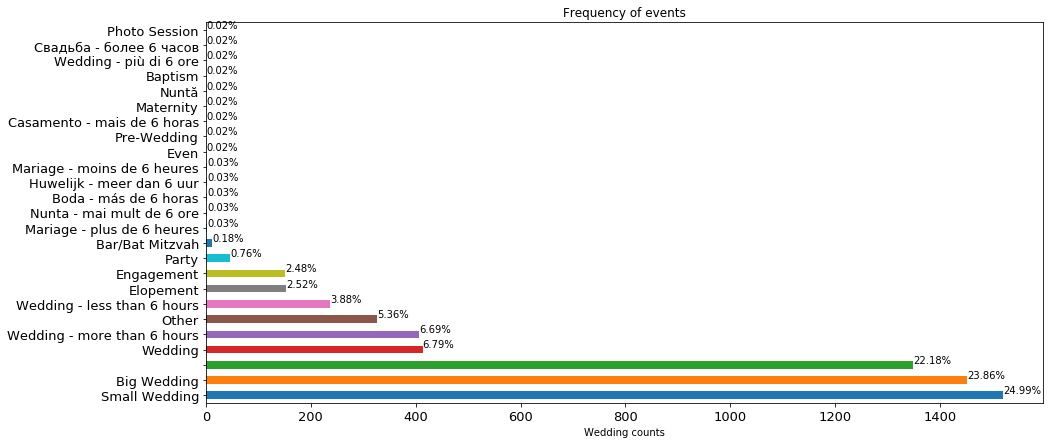

In [179]:
ax = wedding_data['Type'].value_counts().plot(kind='barh', figsize=(15,7),fontsize=13)
ax.set_alpha(0.8)
plt.title('Frequency of events')
plt.xlabel ('Wedding counts')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10)


In [47]:
wedding_data['Type'] = wedding_data['Type'].str.strip()

---
** Based on the distribution above:**
1.  \r\n\t\t  and \r\n\t\t\t\t\t\t refer to inquiries where the user didn't provide any value for event type. These can be dropped for our analysis. The assumption here is that the distribution of the even types is homogenously applicable for the entries with missing wedding type value.
2. Non wedding event types that can be dropped:
        - Engagement
        - Other
        - Party
        - Bar/Bat Mitzvah
        - Baptism
        - Pre-Wedding
        - Photo Session
        - Even
        - Maternity
3. Weddings that need to be remapped: To simplify the analysis, we'll map all the weddings to either Small Wedding or Small Wedding.
        - Big weddings = {Wedding - more than 6 hours, Nunta - mai mult de 6 ore, Mariage - plus de 6 heures, Boda - más de 6 horas, Huwelijk - meer dan 6 uur, Wedding - più di 6 ore, Свадьба - более 6 часов, Casamento - mais de 6 horas}
        - Small Weddings = {Wedding - less than 6 hours, Mariage - moins de 6 heures}
        
** Data Transformation: **
Need to write a function to remove the non wedding events and to map the weddings in #3 to the appropriate categories. 

In [673]:
non_wedding_events = ['Engagement', 'Other', 'Party', 'Bar/Bat Mitzvah', 'Baptism', 'Pre-Wedding', 'Photo Session', 'Even', 'Maternity', 'Nuntă']
big_weddings = ['Big Wedding', 'Wedding - more than 6 hours', 'Nunta - mai mult de 6 ore', 'Mariage - plus de 6 heures', 
                'Boda - más de 6 horas', 'Huwelijk - meer dan 6 uur', 'Wedding - più di 6 ore', 'Свадьба - более 6 часов', 'Casamento - mais de 6 horas']
small_weddings = ['Small Wedding','Wedding - less than 6 hours', 'Mariage - moins de 6 heures', 'Elopement']

def cleanAndMapEvents (df):
    #Create a copy of raw dataframe
    df_clean = df.copy()
    
    #Drop the rows will null values for wedding type
    df_clean = df_clean[df_clean['Type'] != '']
    
    #Drop the rows where the values of Type column are in non_wedding_events, i.e drop non-weddings events
    df_clean = df_clean[df_clean['Type'].isin(non_wedding_events) == False]   
    
    #Replace the values in big_weddings with the value 'Big Weddigs'
    df_clean['Type'].replace(big_weddings, 'Big Weddings', inplace = True)
    
    #Replace the values in small_weddings with the value 'Small Weddigs'
    df_clean['Type'].replace(small_weddings, 'Small Weddings', inplace = True)
    
    return (df_clean)


In [674]:
cleaned_events_data = cleanAndMapEvents(wedding_data)
cleaned_events_data.sample (10, random_state= 101)

,ID,Name,Date,Location,Type,Replies,RequestLink
132,3132,Lauren,"Saturday, September 6, 2014","Liverpool, England - UK",Small Weddings,"10 photographers near your location are available,15 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3132
10,6260,Anri,"Tuesday, February 16, 2016",Venice - Italy,Small Weddings,"25 photographers near your location are available,11 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6260
96,6846,Isabella,"Saturday, August 20, 2016",Budapest - Hungary,Small Weddings,"2 photographers near your location are available,27 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6846
246,7496,Jennifer,"Saturday, October 14, 2017","Milwaukee, WI - USA",Big Weddings,"5 photographers near your location are available,48 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7496
61,7061,Aanne,"Friday, February 10, 2017",St Barthélémy - Caribbean,Big Weddings,"5 photographers near your location are available,67 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7061
173,3923,Viviana,"Saturday, February 7, 2015",Talca - Chile,Small Weddings,"2 photographers near your location are available,17 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3923
237,7237,Jo,"Saturday, July 22, 2017",Manchester - UK,Big Weddings,"20 photographers near your location are available,37 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7237
123,8373,Jill,"Saturday, March 30, 2019","Atlanta, GA - USA",Wedding,"4 photographers near your location are available,54 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8373
80,6830,Charlie Lofthouse,"Thursday, June 1, 2017",Bali - Indonesia,Small Weddings,"3 photographers near your location are available,59 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6830
207,7707,Sahil,"Wednesday, November 22, 2017",Goa - India,Big Weddings,"21 photographers near your location are available,65 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7707


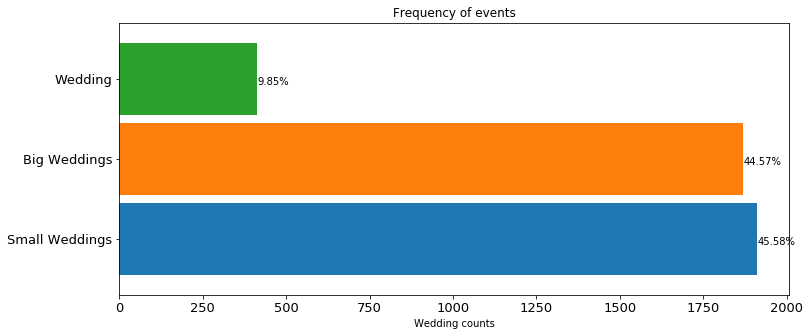

In [675]:
ax = cleaned_data['Type'].value_counts().plot(kind='barh', figsize=(12,5),fontsize=13, width = 0.9)
ax.set_alpha(0.8)
plt.title('Frequency of events')
plt.xlabel ('Wedding counts')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10)


----

** Process Replies Column **

In [676]:
pd.set_option('display.max_colwidth', -1)
cleaned_events_data['Replies'].sample(10, random_state = 101)

132    10 photographers near your location are available,15 photographers around the world are available
10     25 photographers near your location are available,11 photographers around the world are available
96     2 photographers near your location are available,27 photographers around the world are available 
246    5 photographers near your location are available,48 photographers around the world are available 
61     5 photographers near your location are available,67 photographers around the world are available 
173    2 photographers near your location are available,17 photographers around the world are available 
237    20 photographers near your location are available,37 photographers around the world are available
123    4 photographers near your location are available,54 photographers around the world are available 
80     3 photographers near your location are available,59 photographers around the world are available 
207    21 photographers near your location are availabl

In [677]:
df = cleaned_events_data['Replies'].str.split('photographers near your location are available', expand = True)
cleaned_events_data['Local_photogs'] = df[0].where(df[0].str.len()<4)
cleaned_events_data['Global_photogs'] = df[1].where(df[1].notna(),df[0]).str.replace('photographers around the world are available','').str.strip().str.replace(',','')
cleaned_events_data.sample(10,random_state=101)

,ID,Name,Date,Location,Type,Replies,RequestLink,Local_photogs,Global_photogs
132,3132,Lauren,"Saturday, September 6, 2014","Liverpool, England - UK",Small Weddings,"10 photographers near your location are available,15 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3132,10,15
10,6260,Anri,"Tuesday, February 16, 2016",Venice - Italy,Small Weddings,"25 photographers near your location are available,11 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6260,25,11
96,6846,Isabella,"Saturday, August 20, 2016",Budapest - Hungary,Small Weddings,"2 photographers near your location are available,27 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6846,2,27
246,7496,Jennifer,"Saturday, October 14, 2017","Milwaukee, WI - USA",Big Weddings,"5 photographers near your location are available,48 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7496,5,48
61,7061,Aanne,"Friday, February 10, 2017",St Barthélémy - Caribbean,Big Weddings,"5 photographers near your location are available,67 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7061,5,67
173,3923,Viviana,"Saturday, February 7, 2015",Talca - Chile,Small Weddings,"2 photographers near your location are available,17 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3923,2,17
237,7237,Jo,"Saturday, July 22, 2017",Manchester - UK,Big Weddings,"20 photographers near your location are available,37 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7237,20,37
123,8373,Jill,"Saturday, March 30, 2019","Atlanta, GA - USA",Wedding,"4 photographers near your location are available,54 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8373,4,54
80,6830,Charlie Lofthouse,"Thursday, June 1, 2017",Bali - Indonesia,Small Weddings,"3 photographers near your location are available,59 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6830,3,59
207,7707,Sahil,"Wednesday, November 22, 2017",Goa - India,Big Weddings,"21 photographers near your location are available,65 photographers around the world are available",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7707,21,65


In [678]:
# cleaned_events_data['Local_photogs'].astype('int64')
cleaned_events_data['Local_photogs'] = pd.to_numeric(cleaned_events_data['Local_photogs'], errors='coerce')
cleaned_events_data['Global_photogs'] = pd.to_numeric(cleaned_events_data['Global_photogs'], errors='coerce')
cleaned_events_data[['Global_photogs', 'Local_photogs']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4193 entries, 0 to 250
Data columns (total 2 columns):
Global_photogs    4193 non-null int64
Local_photogs     3741 non-null float64
dtypes: float64(1), int64(1)
memory usage: 98.3 KB


In [679]:
cleaned_events_data.drop(['Replies'], inplace = True, axis = 1)

In [680]:
cleaned_events_data.head()

,ID,Name,Date,Location,Type,RequestLink,Local_photogs,Global_photogs
0,8250,David,"Saturday, June 15, 2019","Ithaca, NY - USA",Wedding,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8250,18.0,63
1,8251,Xinru,"Saturday, October 13, 2018",Singapore,Wedding,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8251,7.0,37
2,8252,Megan,"Sunday, October 7, 2018",Riomaggiore - Italy,Wedding,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8252,50.0,52
4,8254,Rajesh,"Friday, October 26, 2018",Mumbai - India,Wedding,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8254,19.0,38
5,8255,Marin,"Saturday, June 1, 2019",Bucharest,Wedding,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8255,34.0,57


** Locations **

In [681]:
cleaned_events_data['Country'] = cleaned_events_data['Location'].str.split('-', expand = True)[1].str.strip()
cleaned_events_data['State/City'] = cleaned_events_data['Location'].str.split('-', expand = True)[0].str.strip()
cleaned_events_data.sample(5, random_state = 101)

,ID,Name,Date,Location,Type,RequestLink,Local_photogs,Global_photogs,Country,State/City
132,3132,Lauren,"Saturday, September 6, 2014","Liverpool, England - UK",Small Weddings,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=3132,10.0,15,UK,"Liverpool, England"
10,6260,Anri,"Tuesday, February 16, 2016",Venice - Italy,Small Weddings,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6260,25.0,11,Italy,Venice
96,6846,Isabella,"Saturday, August 20, 2016",Budapest - Hungary,Small Weddings,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=6846,2.0,27,Hungary,Budapest
246,7496,Jennifer,"Saturday, October 14, 2017","Milwaukee, WI - USA",Big Weddings,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7496,5.0,48,USA,"Milwaukee, WI"
61,7061,Aanne,"Friday, February 10, 2017",St Barthélémy - Caribbean,Big Weddings,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=7061,5.0,67,Caribbean,St Barthélémy


In [682]:
cleaned_events_data.columns

Index(['ID', 'Name', 'Date', 'Location', 'Type', 'RequestLink',
       'Local_photogs', 'Global_photogs', 'Country', 'State/City'],
      dtype='object')

In [683]:
cleaned_events_data = cleaned_events_data[['ID', 'Name', 'Date','Type',
       'Local_photogs', 'Global_photogs', 'Country', 'State/City','RequestLink']]
cleaned_events_data.head()

,ID,Name,Date,Type,Local_photogs,Global_photogs,Country,State/City,RequestLink
0,8250,David,"Saturday, June 15, 2019",Wedding,18.0,63,USA,"Ithaca, NY",https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8250
1,8251,Xinru,"Saturday, October 13, 2018",Wedding,7.0,37,None,Singapore,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8251
2,8252,Megan,"Sunday, October 7, 2018",Wedding,50.0,52,Italy,Riomaggiore,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8252
4,8254,Rajesh,"Friday, October 26, 2018",Wedding,19.0,38,India,Mumbai,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8254
5,8255,Marin,"Saturday, June 1, 2019",Wedding,34.0,57,None,Bucharest,https://www.fearlessphotographers.com/find-wedding-photographers.cfm?requestID=8255


** Breakdown by country **

In [684]:
top_countries = cleaned_events_data.groupby('Country').count()[['ID']].sort_values(by='ID', ascending = False).iloc[0:10]
top_countries

,ID
Country,
USA,1476
Romania,355
UK,299
Canada,204
India,153
France,152
Italy,129
Mexico,90
Greece,86


In [685]:
cleaned_events_data.groupby('Country').count()[['ID']].sort_values(by='ID', ascending = False).iloc[10:].sum()

ID    876
dtype: int64

In [686]:
cleaned_events_data ['Top_Country'] = np.where(cleaned_events_data['Country'].isin(top_countries.index), cleaned_events_data['Country'], 'Other')
cleaned_events_data ['Top_Country'].value_counts()

USA          1476
Other        1171
Romania      355 
UK           299 
Canada       204 
India        153 
France       152 
Italy        129 
Mexico       90  
Greece       86  
Caribbean    78  
Name: Top_Country, dtype: int64

In [691]:
cleaned_events_data.groupby ('Top_Country').count()

,ID,Name,Date,Type,Local_photogs,Global_photogs,Country,State/City,RequestLink
Top_Country,,,,,,,,,
Canada,204,204,204,204,185,204,204,204,204
Caribbean,78,78,78,78,71,78,78,78,78
France,152,152,152,152,152,152,152,152,152
Greece,86,86,86,86,86,86,86,86,86
India,153,153,153,153,151,153,153,153,153
Italy,129,129,129,129,129,129,129,129,129
Mexico,90,90,90,90,90,90,90,90,90
Other,1171,1171,1171,1171,962,1171,876,1171,1171
Romania,355,355,355,355,353,355,355,355,355


In [720]:
summary_data = cleaned_events_data.groupby ('Top_Country').agg({'ID':'count','Local_photogs':'sum', 'Global_photogs': 'sum'}).rename(columns = {'ID':'Inquiry_count'}).sort_values('Inquiry_count', ascending = False)
summary_data

,Inquiry_count,Local_photogs,Global_photogs
Top_Country,,,
USA,1476,10546.0,37483
Other,1171,8284.0,43328
Romania,355,4409.0,7570
UK,299,6497.0,10532
Canada,204,1343.0,4490
India,153,1444.0,4253
France,152,3073.0,5958
Italy,129,3437.0,4281
Mexico,90,1296.0,2627


In [724]:
summary_data['%Inquiry_share'] = np.round(summary_data['Inquiry_count']*100/summary_data['Inquiry_count'].sum(),2)
summary_data['Inquiry_per_local_photog'] = np.round(summary_data['Inquiry_count']/summary_data['Local_photogs'],5)
summary_data['%Inquiry_per_global_photog'] = np.round(summary_data['Inquiry_count']/summary_data['Global_photogs'].sum(),5)
summary_data

,Inquiry_count,Local_photogs,Global_photogs,%Inquiry_share,Inquiry_per_local_photog,%Inquiry_per_global_photog
Top_Country,,,,,,
USA,1476,10546.0,37483,35.20,0.13996,0.01163
Other,1171,8284.0,43328,27.93,0.14136,0.00923
Romania,355,4409.0,7570,8.47,0.08052,0.00280
UK,299,6497.0,10532,7.13,0.04602,0.00236
Canada,204,1343.0,4490,4.87,0.15190,0.00161
India,153,1444.0,4253,3.65,0.10596,0.00121
France,152,3073.0,5958,3.63,0.04946,0.00120
Italy,129,3437.0,4281,3.08,0.03753,0.00102
Mexico,90,1296.0,2627,2.15,0.06944,0.00071
